In [4]:
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import import_ipynb
from cl_sampling import PlanckDataSampler;

In [2]:
height = 2
fontsize = 11/1.2
cm = 1/2.54  # centimeters in inches
width = 8.6*cm # PRL figure width
matplotlib.rcParams.update({
    'font.size'          : fontsize,
    'mathtext.fontset'   : 'cm',
})
Hubbles_to_Gyr = 0.001022

In [3]:
sampler = PlanckDataSampler()

### Goal: Make a PCA of `sampler.cov`
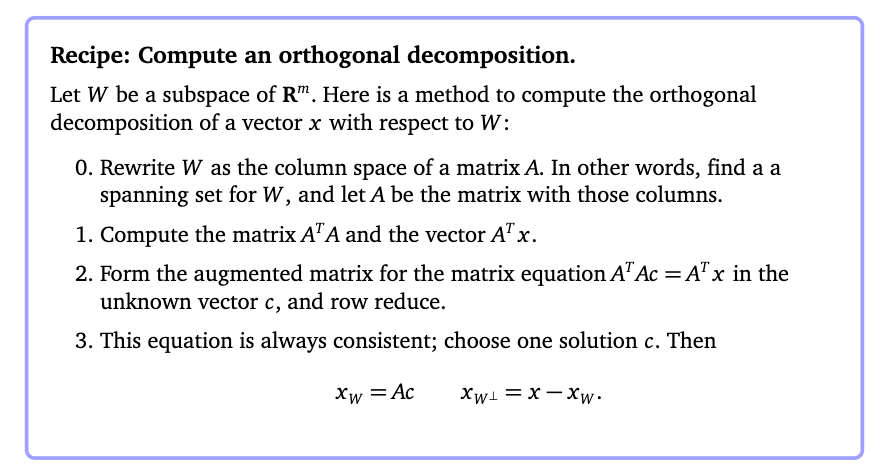

(from https://textbooks.math.gatech.edu/ila/projections.html)

In [216]:
class PCA:
    def __init__(self, sampler, N_pca):
        # Since we PCA the normalized spectra, set the diagonal to unity
        unity_cov = deepcopy(sampler.cov)
        np.fill_diagonal(unity_cov, np.ones(unity_cov.shape[0]))
        
        #eigvals, eigvecs = scipy.linalg.eig(sampler.cov)
        eigvals, eigvecs = scipy.linalg.eig(unity_cov)
        self.original_eigvals = eigvals
        
        # Order eigensystem
        indices = eigvals.argsort()[::-1][:N_pca]
        self.eigvals = eigvals[indices]
        self.eigvecs = eigvecs[:, indices]
        
        # A^T @ A, where A is self.eigvecs
        self.eigvecsTeigvecs = np.matmul(self.eigvecs.T, self.eigvecs)

        self.sampler = sampler
        self.mean = np.concatenate([self.sampler.LCDM['Cltt'], self.sampler.LCDM['Clte'], self.sampler.LCDM['Clee']])
        self.stds = np.sqrt(np.diag(self.sampler.cov))
    
    def normalize(self, samples):
        return self.sampler.SamplesTuple(
                          tt=(samples.tt - self.mean[:self.sampler.nbintt])/self.stds[:self.sampler.nbintt], 
                          te=(samples.te - self.mean[self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte])/self.stds[self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte], 
                          ee=(samples.ee - self.mean[self.sampler.nbintt+self.sampler.nbinte:])/self.stds[self.sampler.nbintt+self.sampler.nbinte:],
                          l_tt=samples.l_tt, l_te=samples.l_te, l_ee=samples.l_ee)
    
    def denormalize(self, samples):
        return self.sampler.SamplesTuple(
                          tt=samples.tt*self.stds[:self.sampler.nbintt] + self.mean[:self.sampler.nbintt], 
                          te=samples.te*self.stds[self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte] + self.mean[self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte], 
                          ee=samples.ee*self.stds[self.sampler.nbintt+self.sampler.nbinte:] + self.mean[self.sampler.nbintt+self.sampler.nbinte:],
                          l_tt=samples.l_tt, l_te=samples.l_te, l_ee=samples.l_ee)
    
    def transform(self, samples):
        samples_normed = self.normalize(samples)
        # NTS: UPDATE SAMPLES TO SAMPLES_NORMED
        samples_aligned = np.concatenate([samples_normed.tt, samples_normed.te, samples_normed.ee], axis=1).T
        sol_array = scipy.linalg.solve(self.eigvecsTeigvecs, np.matmul(self.eigvecs.T, samples_aligned))
        return sol_array
    
    def inverse(self, pca_vec):
        spectra = np.matmul(self.eigvecs, pca_vec)
        tt = spectra[:self.sampler.nbintt, :].T
        te = spectra[self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte, :].T
        ee = spectra[self.sampler.nbintt+self.sampler.nbinte:, :].T
        samples_normed = sampler.SamplesTuple(tt=tt, te=te, ee=ee,
                                 l_tt=self.sampler.l_tt, l_te=self.sampler.l_te, l_ee=self.sampler.l_ee)
        return self.denormalize(samples_normed)

    def explained_variance(self, component_index):
        # WARNING! ISSUES WITH NORMALIZATION DUE TO MACHINE PRECISION
        # WHEN EIGVALS ALL ARE CLOSE TO 1
        res_eigval = self.eigvals
        return res_eigval[component_index]/np.sum(self.original_eigvals)
#        return res_eigval[component_index]/np.sum(res_eigval)
    
    def sample(self, N_samples):
        """Sample from the PCA subspace according to the covmat it is defined by"""
        """
        mean = self.sampler.SamplesTuple(
              tt=[self.sampler.LCDM['Cltt']], 
              te=[self.sampler.LCDM['Clte']], 
              ee=[self.sampler.LCDM['Clee']],
              l_tt=self.sampler.l_tt, l_te=self.sampler.l_te, l_ee=self.sampler.l_ee)
        
        transformed_mean = self.transform(mean) # Will always be zero since transform normalizes! """
        
        # Sample from the mean but with variance added from the diagonalized covmat
        samples = np.random.multivariate_normal(
            mean=np.zeros(self.eigvals.shape[0]), 
            cov=np.diag(self.eigvals),
            size=N_samples
        )
#        return self.sampler.SamplesTuple(tt=samples[:,:self.sampler.nbintt], te=samples[:,self.sampler.nbintt:self.sampler.nbintt+self.sampler.nbinte], ee=samples[:,self.sampler.nbintt+self.sampler.nbinte:],
#                                 l_tt=self.sampler.l_tt, l_te=self.sampler.l_te, l_ee=self.sampler.l_ee)
        return samples.T
        

In [197]:
N_pca = 100
pca = PCA(sampler, N_pca)
pca_vec = pca.transform(sampler.sample_lcdm(1))

# Normalization

In [44]:
scale = 1.0
normtest = sampler.sample_lcdm(1000, normalized=True)
denormtest = sampler.denormalize_lcdm(normtest)

In [45]:
def normalize_samples(samples):
    mean_tt, std_tt = np.mean(samples.tt, axis=0), np.std(samples.tt, axis=0)
    mean_te, std_te = np.mean(samples.te, axis=0), np.std(samples.te, axis=0)
    mean_ee, std_ee = np.mean(samples.ee, axis=0), np.std(samples.ee, axis=0)
    return sampler.SamplesTuple(tt=(samples.tt - mean_tt)/std_tt,
                                te=(samples.te - mean_te)/std_te,
                                ee=(samples.ee - mean_ee)/std_ee,
                                l_tt=samples.l_tt,
                                l_te=samples.l_te,
                                l_ee=samples.l_ee)

test_samples = sampler.sample_lcdm(1000, normalized=False)
normed_sep = normalize_samples(test_samples)

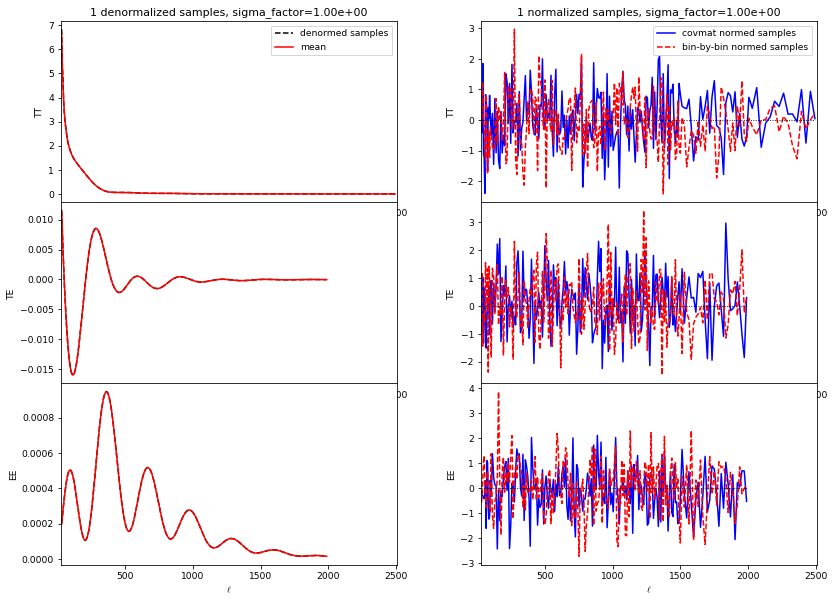

In [46]:
llim = [28, 2506]
marks = 3
lws=0.5
N_plot = 1
idx_plot = 2
sample_alpha = 1
sample_ls = 1.5
fig, ax = plt.subplots(3, 2, figsize=(4*width, 5*height))
ax[0,0].set_title(f'{N_plot} denormalized samples, sigma_factor={scale:.2e}')
ax[0,0].set(xticks=[], xticklabels=[], ylabel=r'TT', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], xticklabels=[], ylabel=r'TE', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'EE', xscale='linear', xlim=llim)
ax[0,1].set_title(f'{N_plot} normalized samples, sigma_factor={scale:.2e}')
ax[0,1].set(xticks=[],xticklabels=[],  ylabel=r'TT', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], xticklabels=[], ylabel=r'TE', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'EE', xscale='linear', xlim=llim)
idx = idx_plot
ax[0,0].plot(denormtest.l_tt, denormtest.tt[idx], 'k--', lw=sample_ls, alpha=sample_alpha, label='denormed samples')
ax[1,0].plot(denormtest.l_te, denormtest.te[idx], 'k--', lw=sample_ls, alpha=sample_alpha)
ax[2,0].plot(denormtest.l_ee, denormtest.ee[idx], 'k--', lw=sample_ls, alpha=sample_alpha)
ax[0,0].plot(denormtest.l_tt, sampler.LCDM['Cltt'], 'r-', lw=sample_ls, alpha=sample_alpha, label='mean')
ax[1,0].plot(denormtest.l_te, sampler.LCDM['Clte'], 'r-', lw=sample_ls, alpha=sample_alpha)
ax[2,0].plot(denormtest.l_ee, sampler.LCDM['Clee'], 'r-', lw=sample_ls, alpha=sample_alpha)

ax[0,1].plot(denormtest.l_tt, normtest.tt[idx], 'b-', lw=sample_ls, alpha=sample_alpha, ms=2, label='covmat normed samples')
ax[1,1].plot(denormtest.l_te, normtest.te[idx], 'b-', lw=sample_ls, alpha=sample_alpha, ms=2)
ax[2,1].plot(denormtest.l_ee, normtest.ee[idx], 'b-', lw=sample_ls, alpha=sample_alpha, ms=2)

ax[0,1].plot(denormtest.l_tt, normed_sep.tt[idx], 'r--', lw=sample_ls, alpha=sample_alpha, ms=2, label='bin-by-bin normed samples')
ax[1,1].plot(denormtest.l_te, normed_sep.te[idx], 'r--', lw=sample_ls, alpha=sample_alpha, ms=2)
ax[2,1].plot(denormtest.l_ee, normed_sep.ee[idx], 'r--', lw=sample_ls, alpha=sample_alpha, ms=2)

ax[0,1].plot(denormtest.l_tt, np.zeros(len(denormtest.l_tt)), 'k:', lw=0.9)
ax[1,1].plot(denormtest.l_te, np.zeros(len(denormtest.l_te)), 'k:', lw=0.9)
ax[2,1].plot(denormtest.l_ee, np.zeros(len(denormtest.l_ee)), 'k:', lw=0.9)
ax[0,0].legend()
ax[0,1].legend()

fig.subplots_adjust(hspace=0, wspace=0.25)
fig.savefig('normalized_spectra.pdf')

# PCA 

In [200]:
N_components = 20
scale = 1.0
test = sampler.sample_lcdm(1000, sigma_scale=scale)
pca = PCA(sampler, N_components)
test_decoded = pca.inverse(pca.transform(test))

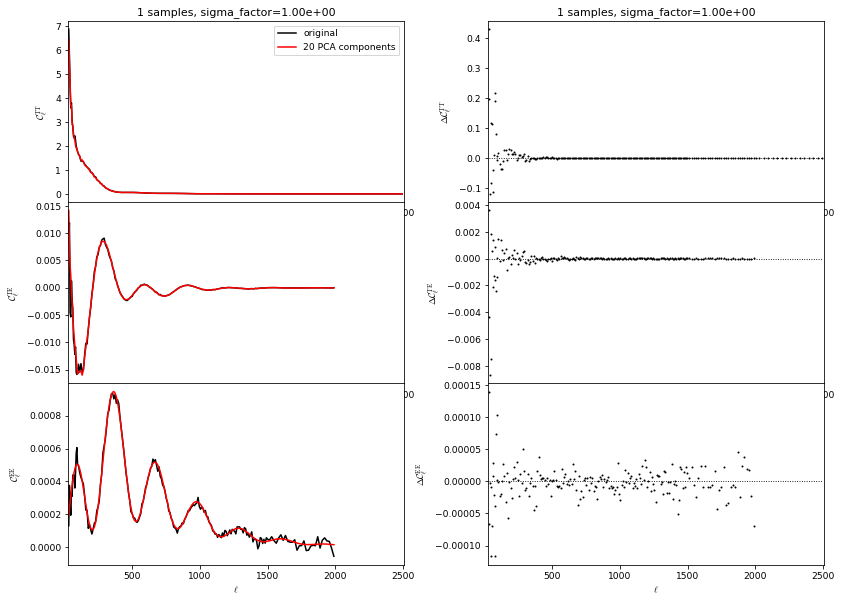

In [86]:
llim = [28, 2506]
marks = 3
lws=0.5
N_plot = 1
idx_plot = 2
sample_alpha = 1
sample_ls = 1.5
fig, ax = plt.subplots(3, 2, figsize=(4*width, 5*height))
ax[0,0].set_title(f'{N_plot} samples, sigma_factor={scale:.2e}')
ax[0,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0,1].set_title(f'{N_plot} samples, sigma_factor={scale:.2e}')
ax[0,1].set(xticks=[],xticklabels=[],  ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], xticklabels=[], ylabel=r'$\Delta  \mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
idx = idx_plot
ax[0,0].plot(test.l_tt, test.tt[idx], 'k-', lw=sample_ls, alpha=sample_alpha, label='original')
ax[1,0].plot(test.l_te, test.te[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
ax[2,0].plot(test.l_ee, test.ee[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
ax[0,0].plot(test_decoded.l_tt, test_decoded.tt[idx], 'r-', lw=sample_ls, alpha=sample_alpha, label=f'{N_components} PCA components')
ax[1,0].plot(test_decoded.l_te, test_decoded.te[idx], 'r-', lw=sample_ls, alpha=sample_alpha)
ax[2,0].plot(test_decoded.l_ee, test_decoded.ee[idx], 'r-', lw=sample_ls, alpha=sample_alpha)

ax[0,1].plot(test.l_tt, test.tt[idx] - test_decoded.tt[idx], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
ax[0,1].plot(test.l_tt, np.zeros(len(test.l_tt)), 'k:', lw=0.9)
ax[1,1].plot(test.l_te, test.te[idx] - test_decoded.te[idx], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
ax[1,1].plot(test.l_tt, np.zeros(len(test.l_tt)), 'k:', lw=0.9)
ax[2,1].plot(test.l_ee, test.ee[idx] - test_decoded.ee[idx], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
ax[2,1].plot(test.l_tt, np.zeros(len(test.l_tt)), 'k:', lw=0.9)
ax[0,0].legend()

fig.subplots_adjust(hspace=0, wspace=0.25)
fig.savefig('pca.pdf')

# Explained variance

/Users/au566942/miniforge3/envs/classpp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


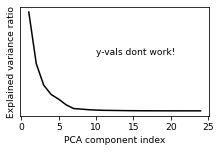

In [225]:
N_pca_max = 25
idx_list = np.arange(1, N_pca_max)
pca = PCA(sampler, N_pca_max)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
ax.set(xlabel='PCA component index', ylabel='Explained variance ratio')
ax.set(yticks=[])
ax.text(10, 0.001640, 'y-vals dont work!')
#ax.set(ylim=[0.0, 0.03])
#ax.set_xscale('log')
ax.plot(idx_list, pca.explained_variance(idx_list), 'k-', label='individual')
#ax.plot(idx_list, np.cumsum(pca.explained_variance(idx_list)), label='cumulative')
fig.savefig('explained_variance.pdf')

# Sampling PCA components to check expressiveness

In [217]:
N_components = 20
scale = 1.0
pca = PCA(sampler, N_components)
samples = pca.inverse(pca.sample(1000))

/var/folders/zr/zbvzsdtx4kzb3_fpksfqd3xx5jyp_x/T/ipykernel_74975/2056555023.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  samples = np.random.multivariate_normal(


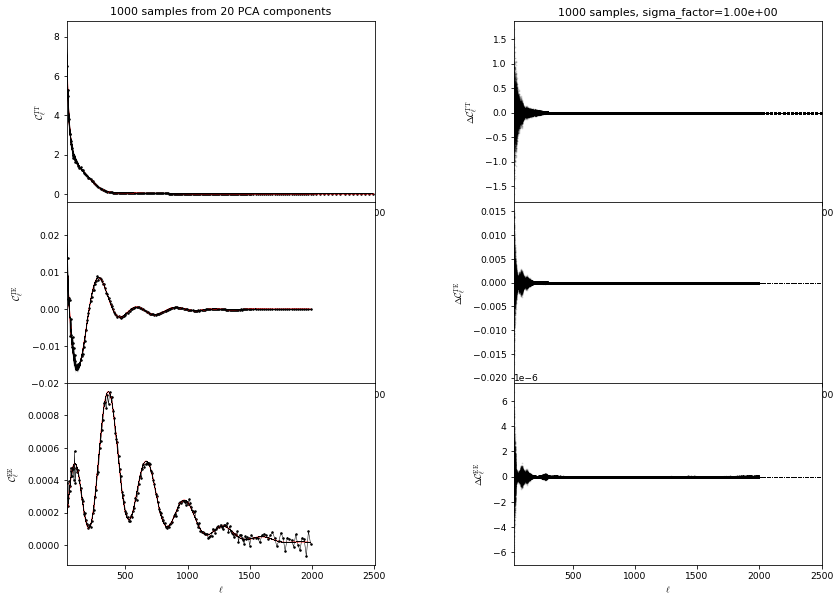

In [221]:
llim = [28, 2506]
marks = 3
lws=0.5
N_plot = 1000
sample_alpha = 1.0009 - 0.000900901*N_plot
sample_ls = 0.50045 - 0.00045045*N_plot
fig, ax = plt.subplots(3, 2, figsize=(4*width, 5*height))
ax[0,0].set_title(f'{N_plot} samples from {N_components} PCA components')
ax[0,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,0].set(xticks=[], xticklabels=[], ylabel=r'$\mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,0].set(xlabel=r'$\ell$', ylabel=r'$\mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
ax[0,0].plot(sampler.l_tt, sampler.Cl_tt, 'k.-', ms=marks, lw=lws)
ax[0,0].plot(sampler.l_tt, sampler.LCDM['Cltt'], 'r-', ms=marks, lw=1)
ax[1,0].plot(sampler.l_te, sampler.Cl_te, 'k.-', ms=marks, lw=lws)
ax[1,0].plot(sampler.l_te, sampler.LCDM['Clte'], 'r-', ms=marks, lw=1)
ax[2,0].plot(sampler.l_ee, sampler.Cl_ee, 'k.-', ms=marks, lw=lws)
ax[2,0].plot(sampler.l_ee, sampler.LCDM['Clee'], 'r-', ms=marks, lw=1)
ax[0,0].set_title(f'{N_plot} residuals from {N_components} PCA components')
ax[0,1].set(xticks=[],xticklabels=[],  ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{TT}}$', xscale='linear', xlim=llim)
ax[1,1].set(xticks=[], xticklabels=[], ylabel=r'$\Delta  \mathcal{C}_\ell^{\mathrm{TE}}$', xscale='linear', xlim=llim)
ax[2,1].set(xlabel=r'$\ell$', ylabel=r'$\Delta \mathcal{C}_\ell^{\mathrm{EE}}$', xscale='linear', xlim=llim)
for idx in range(N_plot):
    ax[0,0].plot(sampler.l_tt, samples.tt[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[1,0].plot(sampler.l_te, samples.te[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[2,0].plot(sampler.l_ee, samples.ee[idx], 'k-', lw=sample_ls, alpha=sample_alpha)
    ax[0,1].plot(sampler.l_tt, samples.tt[idx] - sampler.LCDM['Cltt'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[0,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[1,1].plot(sampler.l_te, samples.te[idx] - sampler.LCDM['Clte'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[1,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)
    ax[2,1].plot(sampler.l_ee, samples.ee[idx] - sampler.LCDM['Clee'], 'k.', lw=sample_ls, alpha=sample_alpha, ms=2)
    ax[2,1].plot(sampler.l_tt, np.zeros(len(sampler.l_tt)), 'k:', lw=0.9)

fig.subplots_adjust(hspace=0, wspace=0.45)
fig.savefig('pca_samples.pdf')